In [1]:
# Import necessary libraries
import os
import base64
import re
from langchain_ibm import ChatWatsonx
from langchain_core.messages import HumanMessage, SystemMessage
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from io import BytesIO
from PIL.ImageFile import ImageFile
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
# Load environment variables
load_dotenv(override=True)

True

In [3]:
# Fetch environment variables correctly
WATSONX_URL = os.getenv("WATSONX_URL", "").strip()
WATSONX_PROJECT_ID = os.getenv("WATSONX_PROJECT_ID", "").strip()
WATSONX_APIKEY = os.getenv("WATSONX_APIKEY", "").strip()

In [4]:
# Clean up the URL - extract just the base domain
def clean_watsonx_url(url):
    # Extract the base domain using regex
    match = re.match(r'https?://([^/]+)', url)
    if match:
        base_domain = match.group(0)
        return base_domain
    return url

# Clean the URL to get just the base domain
cleaned_url = clean_watsonx_url(WATSONX_URL)

In [5]:
# Debugging: Print the loaded values
print(f"Original WATSONX_URL: {WATSONX_URL}")
print(f"Cleaned WATSONX_URL: {cleaned_url}")
print(f"Project ID length: {len(WATSONX_PROJECT_ID)}")
print(f"API Key length: {len(WATSONX_APIKEY)}")

Original WATSONX_URL: https://us-south.ml.cloud.ibm.com
Cleaned WATSONX_URL: https://us-south.ml.cloud.ibm.com
Project ID length: 36
API Key length: 44


In [6]:
def initialize_watsonx_model(url, project_id, apikey, 
                             model_id="mistralai/pixtral-12b", 
                             max_tokens=200, min_new_tokens=1, temperature=0, top_k=50, 
                             top_p=1, repetition_penalty=1, stop_sequences=[]):
    params = {
        GenParams.MIN_NEW_TOKENS: min_new_tokens,
        GenParams.MAX_NEW_TOKENS: max_tokens,
        GenParams.TEMPERATURE: temperature,
        GenParams.TOP_K: top_k,
        GenParams.TOP_P: top_p,
        GenParams.REPETITION_PENALTY: repetition_penalty,
        GenParams.STOP_SEQUENCES: stop_sequences
    }
    
    # Create credentials dictionary
    credentials = {
        "url": url,
        "apikey": apikey
    }
    
    print(f"Using URL for initialization: {url}")
    print(f"Using model: {model_id}")
    
    try:
        watsonx_llm = ChatWatsonx(
            model_id=model_id,
            credentials=credentials,
            project_id=project_id,
            params=params,
        )
        return watsonx_llm
    except Exception as e:
        print(f"Initialization attempt failed: {str(e)}")
        raise

In [7]:
# Initialize the model with proper error handling
try:
    # Use Pixtral model which supports multimodal capabilities
    watsonx_model = initialize_watsonx_model(
        cleaned_url, 
        WATSONX_PROJECT_ID, 
        WATSONX_APIKEY,
        model_id="meta-llama/llama-3-2-90b-vision-instruct"  # Explicitly specify Pixtral
    )
    print("Model initialized successfully")
except Exception as e:
    print(f"Error initializing model: {str(e)}")
    # Provide more helpful error information
    if not WATSONX_URL or WATSONX_URL == "":
        print("WATSONX_URL environment variable is empty or not set")
    if not WATSONX_PROJECT_ID or WATSONX_PROJECT_ID == "":
        print("WATSONX_PROJECT_ID environment variable is empty or not set")
    if not WATSONX_APIKEY or WATSONX_APIKEY == "":
        print("WATSONX_APIKEY environment variable is empty or not set")
        
    print("\nTROUBLESHOOTING STEPS:")
    print("1. Verify that 'mistralai/pixtral-12b' is available in your WatsonX instance")
    print("2. If using a different multimodal model, update the model_id parameter")
    print("3. Check your WatsonX subscription level - multimodal models may require specific plans")
    print("4. Confirm your API key has permissions to access this model")
    
    raise



Using URL for initialization: https://us-south.ml.cloud.ibm.com
Using model: meta-llama/llama-3-2-90b-vision-instruct
Model initialized successfully


In [8]:
def load_image_as_base64(path):
    with open(path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    return image_base64

def encode_image_to_base64(image: str | ImageFile):
    if isinstance(image, str):
        if not os.path.exists(image):
            raise FileNotFoundError(f"Image file not found: {image}")
        return load_image_as_base64(image)
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return image_base64

def construct_message(image_data, prompt_text, system_message="", image_format="png"):
    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt_text},
            {"type": "image_url", "image_url": {"url": f"data:image/{image_format};base64,{image_data}"}}
        ]
    )
    if system_message:
        sys_message = SystemMessage(content=system_message)
        return [sys_message, message]
    return [message]

def chat_with_image(model, image, prompt, system_message=""):
    try:
        print(f"Processing image: {image if isinstance(image, str) else 'PIL Image object'}")
        
        # Determine image format
        image_format = "png"
        if isinstance(image, str) and image.lower().endswith((".jpeg", ".jpg")):
            image_format = "jpeg"
            
        # Convert image to base64
        print("Converting image to base64...")
        image_data = encode_image_to_base64(image)
        print(f"Base64 conversion complete. Length: {len(image_data)}")
        
        # Construct message
        print("Constructing message with image...")
        message = construct_message(image_data, prompt, system_message, image_format)
        
        # Invoke model
        print("Invoking model...")
        response = model.invoke(message)
        print("Model response received")
        
        return response.content
    except Exception as e:
        print(f"Detailed error in chat_with_image: {str(e)}")
        raise

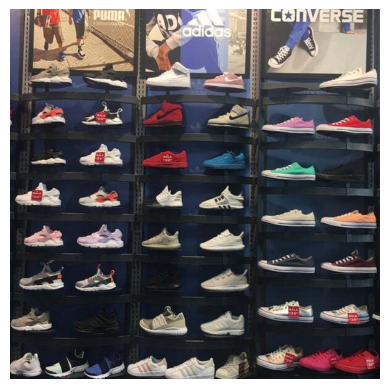

In [14]:
# Load the image
image_path = "images/store-4.jpg"  # Ensure this file is in the same directory or provide full path
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axis
plt.show()


In [16]:
# Only run if model initialization was successful
if 'watsonx_model' in locals():
    try:
        image_path = "images/store-4.jpg"
        # Check if image exists
        if not os.path.exists(image_path):
            print(f"WARNING: Image file '{image_path}' not found!")
            alternative_images = [f for f in os.listdir('.') if f.endswith(('.jpg', '.jpeg', '.png'))]
            if alternative_images:
                image_path = alternative_images[0]
                print(f"Using alternative image: {image_path}")
            else:
                raise FileNotFoundError(f"No image files found in current directory")
        
        prompt_text = (
            "Describe this image in as much detail as possible."
            "Pay close attention to the image and use the following details in your answer: Product names, product placement, shelf issues."
        )
        print(f"Using image: {image_path}")
        print(f"With prompt: '{prompt_text}'")
        
        # Chat with the image
        response = chat_with_image(watsonx_model, image_path, prompt_text)
        print("\nModel Response:")
        print(response)
    except Exception as e:
        print(f"Error during image processing: {str(e)}")

Using image: images/store-4.jpg
With prompt: 'Describe this image in as much detail as possible.Pay close attention to the image and use the following details in your answer: Product names, product placement, shelf issues.'
Processing image: images/store-4.jpg
Converting image to base64...
Base64 conversion complete. Length: 74468
Constructing message with image...
Invoking model...
Model response received

Model Response:
The image depicts a shoe store display featuring three shelves, each with five rows of shoes. The top row showcases advertisements for Puma, Adidas, and Converse, while the remaining rows are filled with various shoes from these brands.

**Shoe Display:**

*   **Top Row:** Advertisements for Puma, Adidas, and Converse
*   **Remaining Rows:** Various shoes from Puma, Adidas, and Converse

**Shoe Brands:**

*   **Puma:** Featured on the left side of the top row
*   **Adidas:** Displayed in the middle of the top row
*   **Converse:** Showcased on the right side of the t